In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format='retina'

BEST_SINGLE_MODEL_MLITE = {
    "trial": "best_single_model_mlite",
    "accuracy": 72.04,
    "loss": 0.0, # Train loss
    "ensemble_size": 1,
    "tag": "jscmlite_deg2",
}
BEST_SINGLE_MODEL_XL = {
    "trial": "best_single_model_xl",
    "accuracy": 74.81,
    "loss": 0.0, # Train loss
    "ensemble_size": 1,
    "tag": "jscxl_deg2",
}
BEST_SINGLE_MODEL_MLITE_DF = pd.DataFrame(BEST_SINGLE_MODEL_MLITE, index=[0])
BEST_SINGLE_MODEL_XL_DF = pd.DataFrame(BEST_SINGLE_MODEL_XL, index=[0])

In [2]:
def parse_ensembling_experiment(experiment_dir):
    """
    Parse ensemble learning experiment directory into dataframe
    """
    accuracy_files = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            # Find log file
            for f in os.listdir(single_run_dir):
                if "accuracy.txt" in f:
                    accuracy_files.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for acc_f in accuracy_files:
        # Example accuracy file
        # averaging_small_ensemble_size2_loss=0.838_accuracy.txt
        # Get accuracy
        with open(acc_f, "r") as f:
            acc = float(f.readlines()[-1])
        trial = acc_f.split("/")[-2]
        # Get loss
        txt_file = acc_f.split("/")[-1]
        loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
        ensemble_size = int(re.findall(f"ensemble_size(\d+)", txt_file)[0])
        # Get tag on model training method
        if "jscm_lite_deg2_shared_io" in trial:
            model_size = "jscmlite_deg2_shared_io"
        elif "jscmlite_deg2" in trial:
            model_size = "jscmlite_deg2"
        elif "jscxl_deg2_shared_io" in trial:
            model_size = "jscxl_deg2_shared_io"
        elif "jscxl_deg2" in trial:
            model_size = "jscxl_deg2"
        else:
            model_size = "deg1"
        with open(results_file, "a") as f:
            f.write(f"{trial}, {acc:.2f}, {loss:.3f}, {ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df

def parse_seq_ensemble_exp(experiment_dir):
    """
    Parse sequentially trained ensemble learning experiment directory into
    dataframe
    """
    ensemble_perfs = []
    for d in os.listdir(experiment_dir):
        single_run_dir = os.path.join(experiment_dir, d)
        if os.path.isdir(single_run_dir):
            for f in os.listdir(single_run_dir):
                if "ensemble_perf.txt" in f:
                    ensemble_perfs.append(os.path.join(experiment_dir, d, f))
    results_file = os.path.join(experiment_dir, "results.csv")
    with open(results_file, "w") as f:
        f.write("trial,accuracy,loss,ensemble_size,model_size\n")
    for ens_perf_f in ensemble_perfs:
        trial = ens_perf_f.split("/")[-2]
        # Get tag on model training method
        if "jscmlite_deg2" in trial:
            model_size = "jscmlite_deg2"
        elif "jscxl_deg2" in trial:
            model_size = "jscxl_deg2"
        else:
            model_size = "deg1"
        # Get accuracy, val loss, and ensemble size from ensemble_perf log
        with open(ens_perf_f, "r") as f:
            for l in f.readlines():
                if "Ensemble size" in l and "Accuracy" in l:
                    ensemble_size = re.findall(f"Ensemble size \d+", l)[-1]
                    ensemble_size = int(re.findall(f"\d+", ensemble_size)[0])
                    loss = float(re.findall(f"\d+\.\d+", l)[0])
                    acc = float(re.findall(f"\d+\.\d+", l)[1])
                    with open(results_file, "a") as f:
                        f.write(f"{trial}, {acc:.3f}, {loss:.3f}, " \
                                f"{ensemble_size},{model_size}\n")
    df = pd.read_csv(results_file)
    df = df.sort_values("accuracy", ignore_index=True, ascending=False)
    df.to_csv(results_file, index=False)
    return df 

# TODO: Parse individual model performance for sequentially trained ensembles


def add_single_model_data(df, add_multi_deg=False):
    """
    Concat single model dataframes to given dataframe
    """
    df = pd.concat([df, BEST_SINGLE_MODEL_MLITE_DF], ignore_index=True)
    df = pd.concat([df, BEST_SINGLE_MODEL_XL_DF], ignore_index=True)
    return df

def plot_two_ensembles(df, model1, model2):
    plot_df = df.loc[df["model_size"].isin([model1, model2])]
    display(plot_df)
    fig, ax = plt.subplots(figsize=(6, 4))
    ax = sns.lineplot(
        data=plot_df, 
        x="ensemble_size", 
        y="accuracy", 
        ax=ax, 
        hue="tag", 
        errorbar=(lambda x: (x.min(), x.max())), 
        err_kws={"linewidth": 2}, 
        linewidth=2,
    )
    plt.axhline(y=BEST_SINGLE_MODEL["accuracy"], linewidth=1, linestyle="--", color="maroon", label="Single model")
    ax.grid()
    ax.legend()
    ax.set_title("Averaging")
    ax.set_ylabel("Accuracy (%)")
    ax.set_xlabel("Ensemble Size")
    fig.tight_layout()
    plt.savefig(f"averaging_acc_v_ensemble_size_{model1}_v_{model2}_lineplot.pdf")
    plt.savefig(f"averaging_acc_v_ensemble_size_{model1}_v_{model2}_lineplot.png")

<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:73: SyntaxWarning: invalid escape sequence '\d'
<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:75: SyntaxWarning: invalid escape sequence '\d'
<>:76: SyntaxWarning: invalid escape sequence '\d'
<>:25: SyntaxWarning: invalid escape sequence '\d'
<>:26: SyntaxWarning: invalid escape sequence '\d'
<>:73: SyntaxWarning: invalid escape sequence '\d'
<>:74: SyntaxWarning: invalid escape sequence '\d'
<>:75: SyntaxWarning: invalid escape sequence '\d'
<>:76: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3587008/461536562.py:25: SyntaxWarning: invalid escape sequence '\d'
  loss = float(re.findall(f'\d+\.\d+', txt_file)[-1])
/tmp/ipykernel_3587008/461536562.py:26: SyntaxWarning: invalid escape sequence '\d'
  ensemble_size = int(re.findall(f"ensemble_size(\d+)", txt_file)[0])
/tmp/ipykernel_3587008/461536562.py:73: SyntaxWarning: invalid escape sequence '\d'
  ensemble_s

## Averaging

In [3]:
experiment_dir = "../averaging"
df = parse_ensembling_experiment(experiment_dir)
# df = add_single_model_data(df)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
averaging_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,averaging_jscxl_deg2_ensemble_size16,75.42,0.681,16,jscxl_deg2
1,averaging_jscxl_deg2_ensemble_size32,75.37,0.681,32,jscxl_deg2
2,averaging_jscxl_deg2_ensemble_size4,75.35,0.684,4,jscxl_deg2
3,averaging_jscxl_deg2_ensemble_size8,75.35,0.682,8,jscxl_deg2
4,averaging_jscxl_deg2_shared_io_ensemble_size8,75.10,0.690,8,jscxl_deg2_shared_io
5,averaging_jscxl_deg2_ensemble_size2,75.04,0.693,2,jscxl_deg2
6,averaging_jscxl_deg2_shared_io_ensemble_size4,74.92,0.694,4,jscxl_deg2_shared_io
7,averaging_jscmlite_deg2_ensemble_size32,74.91,0.697,32,jscmlite_deg2
8,averaging_jscxl_deg2_shared_io_ensemble_size2,74.83,0.697,2,jscxl_deg2_shared_io
9,averaging_jscxl_deg2_ensemble_size1,74.81,0.699,1,jscxl_deg2


,trial,accuracy,loss,ensemble_size,model_size
0,averaging_jscxl_deg2_ensemble_size16,75.42,0.681,16,jscxl_deg2
1,averaging_jscxl_deg2_ensemble_size32,75.37,0.681,32,jscxl_deg2
2,averaging_jscxl_deg2_ensemble_size4,75.35,0.684,4,jscxl_deg2
3,averaging_jscxl_deg2_ensemble_size8,75.35,0.682,8,jscxl_deg2
4,averaging_jscxl_deg2_shared_io_ensemble_size8,75.10,0.690,8,jscxl_deg2_shared_io
5,averaging_jscxl_deg2_ensemble_size2,75.04,0.693,2,jscxl_deg2
6,averaging_jscxl_deg2_shared_io_ensemble_size4,74.92,0.694,4,jscxl_deg2_shared_io
7,averaging_jscmlite_deg2_ensemble_size32,74.91,0.697,32,jscmlite_deg2
8,averaging_jscxl_deg2_shared_io_ensemble_size2,74.83,0.697,2,jscxl_deg2_shared_io
9,averaging_jscxl_deg2_ensemble_size1,74.81,0.699,1,jscxl_deg2


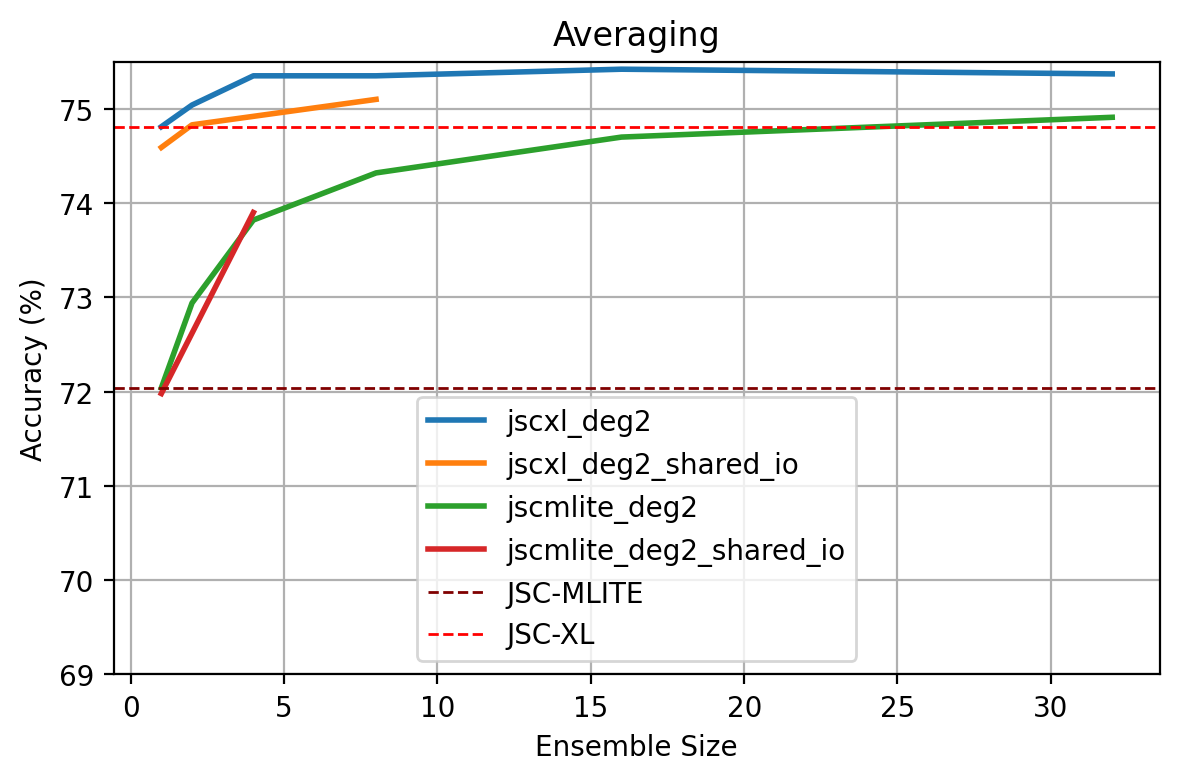

In [4]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # legend="auto",
)
plt.axhline(y=BEST_SINGLE_MODEL_MLITE["accuracy"], linewidth=1, linestyle="--", color="maroon", label="JSC-MLITE")
plt.axhline(y=BEST_SINGLE_MODEL_XL["accuracy"], linewidth=1, linestyle="--", color="red", label="JSC-XL")
# ax.set_ylim([93, 98.5])
# fig.legend(bbox_to_anchor=(0.5, -0.2), loc="lower center")
ax.grid()
ax.set_title("Averaging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
ax.legend(loc="lower center")
ax.set_ylim([69, 75.5])
fig.tight_layout()
plt.savefig("averaging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("averaging_acc_v_ensemble_size_lineplot.png")

## Bagging

In [9]:
experiment_dir = "../bagging"
df = parse_seq_ensemble_exp(experiment_dir)
# df = add_single_model_data(df, add_multi_deg=True)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
bagging_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,bagging_jscxl_deg2_ensemble_size32,75.202,0.689,26,jscxl_deg2
1,bagging_jscxl_deg2_ensemble_size32,75.193,0.689,23,jscxl_deg2
2,bagging_jscxl_deg2_ensemble_size32,75.192,0.689,25,jscxl_deg2
3,bagging_jscxl_deg2_ensemble_size32,75.192,0.689,31,jscxl_deg2
4,bagging_jscxl_deg2_ensemble_size32,75.192,0.689,22,jscxl_deg2
...,...,...,...,...,...
59,bagging_jscmlite_deg2_ensemble_size32,72.783,0.760,5,jscmlite_deg2
60,bagging_jscmlite_deg2_ensemble_size32,72.725,0.761,4,jscmlite_deg2
61,bagging_jscmlite_deg2_ensemble_size32,72.609,0.763,3,jscmlite_deg2
62,bagging_jscmlite_deg2_ensemble_size32,72.412,0.768,2,jscmlite_deg2


,trial,accuracy,loss,ensemble_size,model_size
0,bagging_jscxl_deg2_ensemble_size32,75.202,0.689,26,jscxl_deg2
1,bagging_jscxl_deg2_ensemble_size32,75.193,0.689,23,jscxl_deg2
2,bagging_jscxl_deg2_ensemble_size32,75.192,0.689,25,jscxl_deg2
3,bagging_jscxl_deg2_ensemble_size32,75.192,0.689,31,jscxl_deg2
4,bagging_jscxl_deg2_ensemble_size32,75.192,0.689,22,jscxl_deg2
...,...,...,...,...,...
59,bagging_jscmlite_deg2_ensemble_size32,72.783,0.760,5,jscmlite_deg2
60,bagging_jscmlite_deg2_ensemble_size32,72.725,0.761,4,jscmlite_deg2
61,bagging_jscmlite_deg2_ensemble_size32,72.609,0.763,3,jscmlite_deg2
62,bagging_jscmlite_deg2_ensemble_size32,72.412,0.768,2,jscmlite_deg2


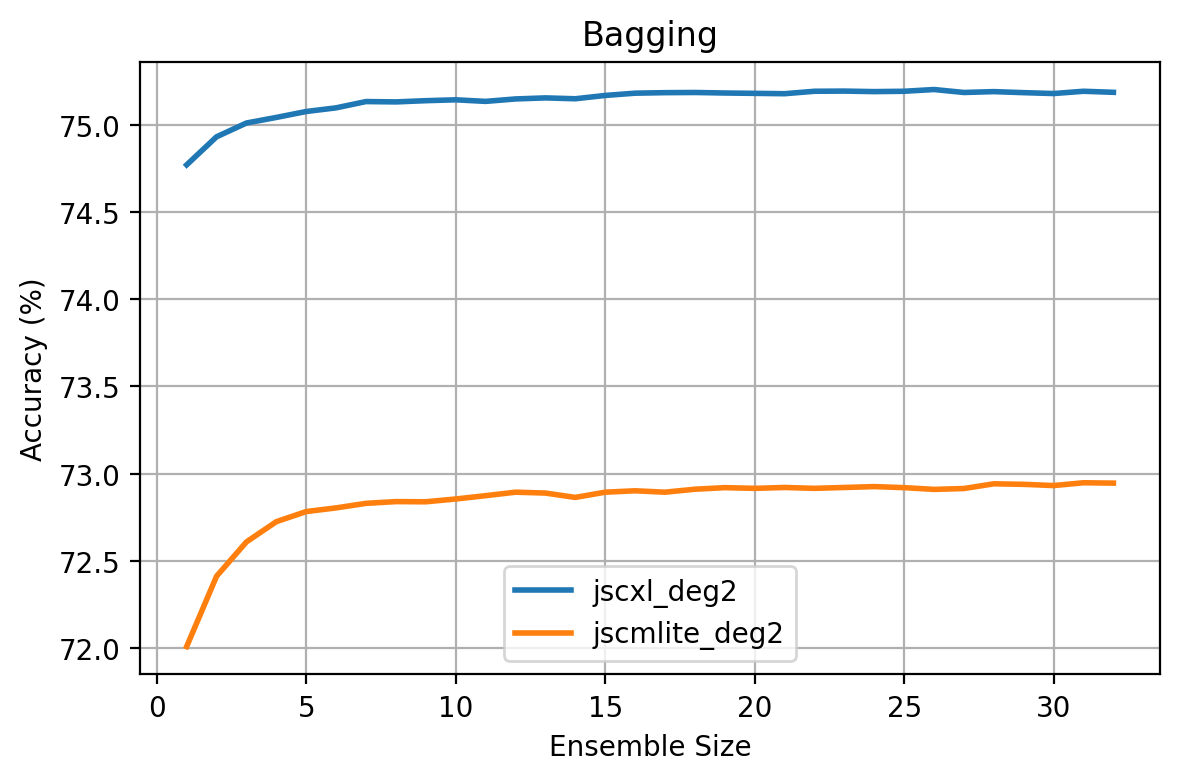

In [10]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # legend="auto",
)
ax.grid()
ax.set_title("Bagging")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
ax.legend(loc="lower center")
# ax.set_ylim([93, 98.5])
# fig.legend(bbox_to_anchor=(0.5, -0.2), loc="lower center")
fig.tight_layout()
plt.savefig("bagging_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("bagging_acc_v_ensemble_size_lineplot.png")

## AdaBoost

In [3]:
experiment_dir = "../adaboost"
df = parse_seq_ensemble_exp(experiment_dir)
# df = add_single_model_data(df, add_multi_deg=True)
df = df.sort_values("accuracy", ignore_index=True, ascending=False)
adaboost_df = df
df

,trial,accuracy,loss,ensemble_size,model_size
0,adaboost_jscxl_deg2_ensemble_size32,74.855,1.078,1,jscxl_deg2
1,adaboost_jscxl_deg2_ensemble_size32,74.855,1.131,3,jscxl_deg2
2,adaboost_jscxl_deg2_ensemble_size32,74.855,1.150,4,jscxl_deg2
3,adaboost_jscxl_deg2_ensemble_size32,74.855,1.099,2,jscxl_deg2
4,adaboost_jscxl_deg2_ensemble_size32,74.504,1.174,5,jscxl_deg2
...,...,...,...,...,...
59,adaboost_jscmlite_deg2_ensemble_size32,70.082,1.335,20,jscmlite_deg2
60,adaboost_jscmlite_deg2_ensemble_size32,70.073,1.358,29,jscmlite_deg2
61,adaboost_jscmlite_deg2_ensemble_size32,70.057,1.360,30,jscmlite_deg2
62,adaboost_jscmlite_deg2_ensemble_size32,70.055,1.338,21,jscmlite_deg2


,trial,accuracy,loss,ensemble_size,model_size
0,adaboost_jscxl_deg2_ensemble_size32,74.855,1.078,1,jscxl_deg2
1,adaboost_jscxl_deg2_ensemble_size32,74.855,1.131,3,jscxl_deg2
2,adaboost_jscxl_deg2_ensemble_size32,74.855,1.150,4,jscxl_deg2
3,adaboost_jscxl_deg2_ensemble_size32,74.855,1.099,2,jscxl_deg2
4,adaboost_jscxl_deg2_ensemble_size32,74.504,1.174,5,jscxl_deg2
...,...,...,...,...,...
59,adaboost_jscmlite_deg2_ensemble_size32,70.082,1.335,20,jscmlite_deg2
60,adaboost_jscmlite_deg2_ensemble_size32,70.073,1.358,29,jscmlite_deg2
61,adaboost_jscmlite_deg2_ensemble_size32,70.057,1.360,30,jscmlite_deg2
62,adaboost_jscmlite_deg2_ensemble_size32,70.055,1.338,21,jscmlite_deg2


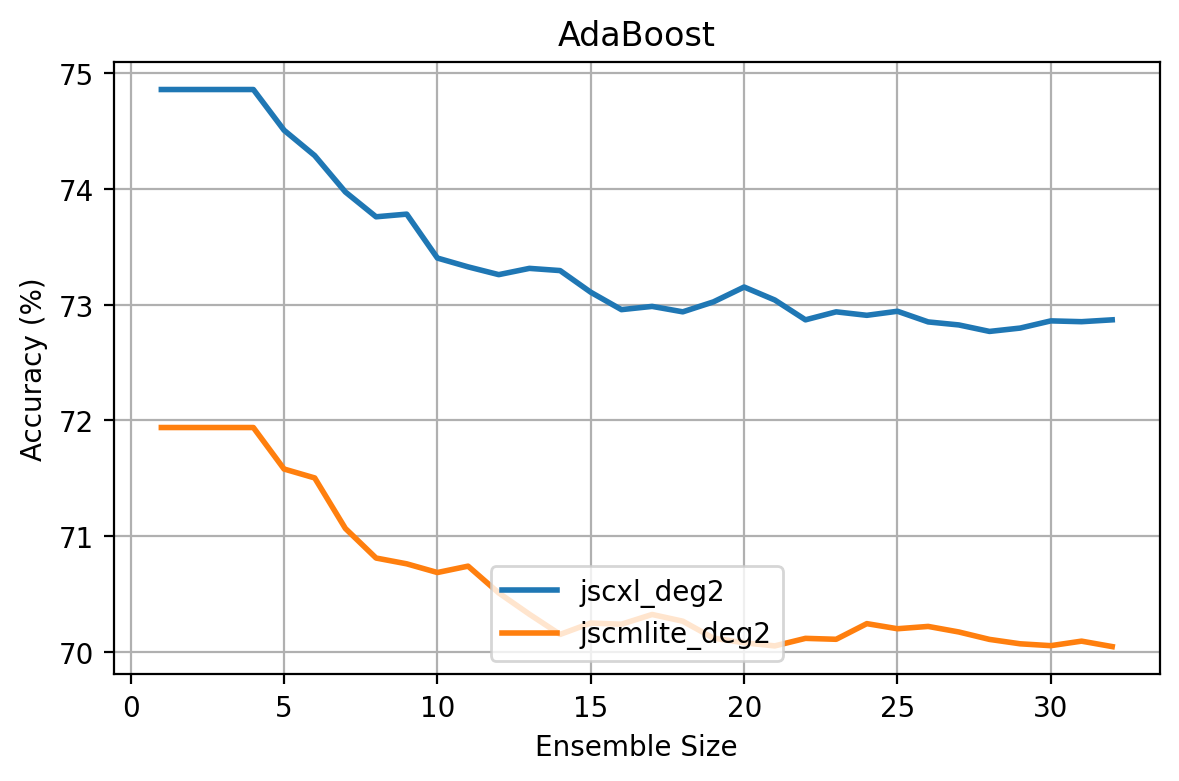

In [4]:
"""
Line plot of accuracy vs ensemble size
"""
plot_df = df
display(plot_df)
fig, ax = plt.subplots(figsize=(6, 4))
ax = sns.lineplot(
    data=plot_df, 
    x="ensemble_size", 
    y="accuracy", 
    ax=ax, 
    hue="model_size", 
    linewidth=2,
    # legend="auto",
)
ax.grid()
ax.set_title("AdaBoost")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Ensemble Size")
ax.legend(loc="lower center")
# ax.set_ylim([93, 98.5])
# fig.legend(bbox_to_anchor=(0.5, -0.2), loc="lower center")
fig.tight_layout()
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.pdf")
plt.savefig("adaboost_acc_v_ensemble_size_lineplot.png")

## Ensembling Comparison

In [ ]:
averaging_df["ensemble_method"] = averaging_df["tag"].apply(lambda x: "Averaging")
bagging_df["ensemble_method"] = bagging_df["tag"].apply(lambda x: "Bagging")
adaboost_df["ensemble_method"] = adaboost_df["tag"].apply(lambda _: "AdaBoost")
all_df = pd.concat([averaging_df, bagging_df, adaboost_df])
all_df = add_single_model_data(all_df)
all_df